In [14]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from torchvision import transforms

from functions import classic_ml
import random
from PIL import Image
import cv2

from sklearn.decomposition import IncrementalPCA

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import image
from skimage import transform, exposure, io
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)

In [4]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
4594,HAM_0005612,ISIC_0024981,bkl,histo,80,male,scalp,False,HAM10000_images_part_1/bkl/ISIC_0024981.jpg,0
22246,HAM_0003610,ISIC_0028937,bcc,histo,80,male,face,False,HAM10000_images_part_1/bcc/ISIC_0028937.jpg,5
14497,HAM_0002115,ISIC_0032408,mel,histo,60,female,upper extremity,False,HAM10000_images_part_2/mel/ISIC_0032408.jpg,3
20701,HAM_0000286,ISIC_0029099,vasc,consensus,70,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0029099.jpg,4
3625,HAM_0006136,ISIC_0028910,nv,follow_up,40,female,trunk,False,HAM10000_images_part_1/nv/ISIC_0028910.jpg,1


In [5]:
data.shape

(30905, 10)

In [6]:
# use the same mean and std as before
norm_means = np.array([0.77148203, 0.55764165, 0.58345652])
norm_std =  np.array([0.12655577, 0.14245141, 0.15189891])
img_h, img_w = 224, 224

**Balanced subsamlpe split**

In [7]:
selected_data = data.groupby('dx').apply(lambda x: x.sample(n=250)).reset_index(drop=True)
selected_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
0,HAM_0000982,ISIC_0032356,akiec,histo,60,male,lower extremity,False,HAM10000_images_part_2/akiec/ISIC_0032356.jpg,6
1,HAM_0002745,ISIC_0024562,akiec,histo,75,male,chest,False,HAM10000_images_part_1/akiec/ISIC_0024562.jpg,6
2,HAM_0002954,ISIC_0024329,akiec,histo,75,female,lower extremity,False,HAM10000_images_part_1/akiec/ISIC_0024329.jpg,6
3,HAM_0001621,ISIC_0030297,akiec,histo,70,female,face,False,HAM10000_images_part_2/akiec/ISIC_0030297.jpg,6
4,HAM_0001048,ISIC_0026525,akiec,histo,45,male,face,False,HAM10000_images_part_1/akiec/ISIC_0026525.jpg,6


# PCA

**Dimentionality Reduction**

In order to make sence to use the sklearn library with the classic classifiers we need to handle the high resolution of 30000 images. So we need a dimentionality reduction method that is applicable in images. PCA although is slow, is one of the few ways that supports incremental fitting and also is mathematicly explainable and we can choose the percentage of variance that we need to keep.
Since each image has 3 colors we will apply PCA in each color separetly.

## Dimentionality reduction using PCA

In [8]:
ipca_red = IncrementalPCA(n_components=224)
ipca_green = IncrementalPCA(n_components=224)
ipca_blue = IncrementalPCA(n_components=224)

start_pca = time.time()
for idx, row in tqdm(selected_data.iterrows()):
    img_path = row['image_path']
    red, green, blue = classic_ml.process_image(img_path, img_h, img_w, norm_means, norm_std)
    ipca_red.fit(red)
    ipca_green.fit(green)
    ipca_blue.fit(blue)

end_pca = time.time()
explained_variance_red = ipca_red.explained_variance_ratio_
explained_variance_green = ipca_green.explained_variance_ratio_
explained_variance_blue = ipca_blue.explained_variance_ratio_

print(f'PCA for all colors took {(end_pca - start_pca)/60:.2f} minutes')

1750it [04:42,  6.20it/s]

PCA for all colors took 4.70 minutes


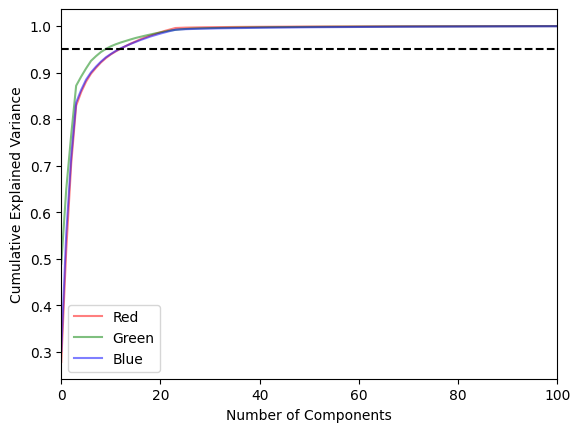

Number of components explaining 95% of the red color variance: 13
Number of components explaining 95% of the green color variance: 10
Number of components explaining 95% of the blue color variance: 13


In [9]:
cumulative_variance_red = np.cumsum(explained_variance_red)
cumulative_variance_green = np.cumsum(explained_variance_green)
cumulative_variance_blue = np.cumsum(explained_variance_blue)

plt.plot(cumulative_variance_red, label='Red', color='red',alpha=0.5)
plt.plot(cumulative_variance_green, label='Green', color='green',alpha=0.5)
plt.plot(cumulative_variance_blue, label='Blue', color='blue',alpha=0.5)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(0.95, 0, 100, color='black', linestyle='--')
plt.xlim(0, 100)
plt.legend()    
plt.show()

n_components_95_red = np.where(cumulative_variance_red >= 0.95)[0][0] + 1
n_components_95_blue = np.where(cumulative_variance_blue >= 0.95)[0][0] + 1
n_components_95_green = np.where(cumulative_variance_green >= 0.95)[0][0] + 1


print(f"Number of components explaining 95% of the red color variance: {n_components_95_red}")
print(f"Number of components explaining 95% of the green color variance: {n_components_95_green}")
print(f"Number of components explaining 95% of the blue color variance: {n_components_95_blue}")

In [8]:
numof_components = max(n_components_95_red, n_components_95_green, n_components_95_blue)
# numof_components=13
numof_components

13

## Apply dimentionality reduction

In [9]:
batch_size = 1000  
transformed_data = []
labels = []
start_ipca = time.time()
for i in tqdm(range(0, len(data), batch_size)):
    batch_paths = data['image_path'][i:i + batch_size].tolist()
    batch_labels = data['dx_cat'][i:i + batch_size].tolist()
    
    batch_processed_images = classic_ml.process_batch_pca(batch_paths=batch_paths, numof_components=numof_components)
    transformed_data.append(batch_processed_images)
    labels.append(batch_labels)

end_ipca = time.time()
print(f'Dimentionality Reduction took {(end_ipca - start_ipca)/60:.2f} minutes')
transformed_data_np = np.concatenate(transformed_data, axis=0)
labels = np.concatenate(labels, axis=0)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [40:57<00:00, 79.27s/it]


Dimentionality Reduction took 40.96 minutes


In [10]:
# np.save('transformed_data_np.npy', transformed_data_np)
# np.save('labels.npy', labels)

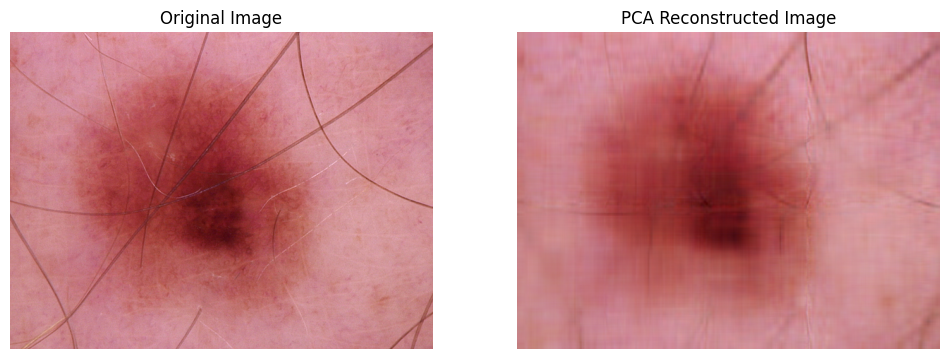

In [22]:
image_path = data['image_path'][100]
image = Image.open(image_path)
image = np.array(image)
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2]

num_components = 13
pca = PCA(n_components=num_components)

red_transformed = pca.fit_transform(red)
red_inverse = pca.inverse_transform(red_transformed)

pca = PCA(n_components=num_components)
green_transformed = pca.fit_transform(green)
green_inverse = pca.inverse_transform(green_transformed)

pca = PCA(n_components=num_components)
blue_transformed = pca.fit_transform(blue)
blue_inverse = pca.inverse_transform(blue_transformed)

img_reconstructed = np.dstack((red_inverse, green_inverse, blue_inverse)).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_reconstructed)
plt.title('PCA Reconstructed Image')
plt.axis('off')

plt.show()


In [9]:
transformed_data_np = np.load('transformed_data_np.npy')
labels = np.load('labels.npy')

We used only RandomForestClassifier and KNeighborsClassifier because of the n_jobs=-1 parameter. Without parallelization the time to fit for only one classifier was extreme.

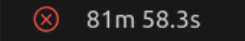

In [9]:
n_samples = transformed_data_np.shape[0]
n_features = transformed_data_np.shape[1] 
images_reshaped = transformed_data_np.reshape(n_samples, n_features)

X_train, X_test, y_train, y_test = train_test_split(images_reshaped, labels, test_size=0.3, random_state=42)
estimators=[RandomForestClassifier(), KNeighborsClassifier()]


In [10]:
start_model=time.time()
results_df=classic_ml.hyperparameter_tuning(X_train, y_train, X_test, y_test, splits=3, n_trials=10, verbose=0, scoring='accuracy', estimators=estimators)
end_model=time.time()
print(f'Hyperparameter tuning and final results for RandomForestClassifier and KNeighborsClassifier took {(end_model - start_model)/60:.2f} minutes')
results_df

  0%|          | 0/2 [00:00<?, ?it/s]

Searching for classifier: RandomForestClassifier


[I 2024-02-16 19:24:56,644] A new study created in memory with name: no-name-17bfe63d-7fff-49e6-9b8a-0d594b457dbe
[I 2024-02-16 19:25:35,605] Trial 9 finished with value: 0.17759903850598624 and parameters: {'n_estimators': 40, 'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 4, 'bootstrap': False, 'n_jobs': -1}. Best is trial 9 with value: 0.17759903850598624.
[I 2024-02-16 19:26:42,219] Trial 4 finished with value: 0.16964822262284474 and parameters: {'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'bootstrap': True, 'n_jobs': -1}. Best is trial 9 with value: 0.17759903850598624.
[I 2024-02-16 19:27:01,557] Trial 6 finished with value: 0.17528775481902648 and parameters: {'n_estimators': 9, 'criterion': 'gini', 'max_depth': 44, 'min_samples_leaf': 3, 'min_samples_split': 7, 'bootstrap': False, 'n_jobs': -1}. Best is trial 9 with value: 0.17759903850598624.
[I 2024-02-16 19:29:35,148] Trial

Best score: 0.2413718723037101
Best parameters: {'n_estimators': 185, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 7, 'bootstrap': False, 'n_jobs': -1}
Searching for classifier: KNeighborsClassifier


[I 2024-02-16 19:35:44,975] A new study created in memory with name: no-name-28988a2c-91e0-4f10-bd00-010119359471
[I 2024-02-16 19:51:12,230] Trial 9 finished with value: 0.1830998936809504 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'p': 2, 'leaf_size': 49, 'n_jobs': -1}. Best is trial 9 with value: 0.1830998936809504.
[I 2024-02-16 19:51:14,558] Trial 0 finished with value: 0.17995654786668516 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'p': 2, 'leaf_size': 20, 'n_jobs': -1}. Best is trial 9 with value: 0.1830998936809504.
[I 2024-02-16 20:14:50,206] Trial 5 finished with value: 0.17880090602320528 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 2, 'leaf_size': 37, 'n_jobs': -1}. Best is trial 9 with value: 0.1830998936809504.
[I 2024-02-16 20:16:14,838] Trial 2 finished with value: 0.17639717098876714 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ba

Best score: 0.2114969801553063
Best parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 1, 'leaf_size': 21, 'n_jobs': -1}
Hyperparameter tuning and final results for RandomForestClassifier and KNeighborsClassifier took 66.32 minutes


,name,score,best_params
0,RandomForestClassifier,0.241372,"{'n_estimators': 185, 'criterion': 'entropy', ..."
1,KNeighborsClassifier,0.211497,"{'n_neighbors': 11, 'weights': 'distance', 'al..."


# Partially fitted Classifiers

Since the dimentionality reduction resulted poor accuracies we will try classifiers which support partial fit in order not to full the memory. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['image_path'], data['dx_cat'], test_size=0.3)
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(selected_data['image_path'], selected_data['dx_cat'], test_size=0.2)

Split a balanced subset

In [10]:
batch_size = X_sel_train.shape[0]  
processed_batches=classic_ml.process_batch_partial_fit(X=X_sel_train, y=y_sel_train, batch_size=batch_size)
batch = list(processed_batches)
sel_images, sel_targets = batch[0]
sel_images_reshaped = sel_images.reshape(sel_images.shape[0], -1)

test_batch = X_sel_test.shape[0]
test_processed_batches=classic_ml.process_batch_partial_fit(X=X_sel_test, y=y_sel_test, batch_size=test_batch)
test_batche = list(test_processed_batches)
X_sel_test, y_sel_test = test_batche[0]
X_sel_test = X_sel_test.reshape(X_sel_test.shape[0], -1)

estimators=[MLPClassifier(),PassiveAggressiveClassifier(),Perceptron(),SGDClassifier()]

**Hyperparameter tuning using OptunaCV**

In [11]:
start = time.time()
results_inc_df=classic_ml.hyperparameter_tuning(X_train=sel_images_reshaped, y_train=sel_targets, X_test=X_sel_test, y_test=y_sel_test, splits=2,  n_trials=15, verbose=0, scoring='accuracy', estimators=estimators)
end = time.time()

  0%|          | 0/4 [00:00<?, ?it/s][I 2024-02-17 00:04:40,235] A new study created in memory with name: no-name-dde6b6c8-ca3d-4057-b969-1cb431e4eaa2


Searching for classifier: MLPClassifier


[I 2024-02-17 00:08:29,624] Trial 14 finished with value: 0.23642857142857143 and parameters: {'hidden_layer_sizes': (50, 100), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.051223755515495024, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'verbose': False, 'early_stopping': True}. Best is trial 14 with value: 0.23642857142857143.
[I 2024-02-17 00:09:17,167] Trial 12 finished with value: 0.3342857142857143 and parameters: {'hidden_layer_sizes': (50, 100), 'activation': 'identity', 'solver': 'adam', 'alpha': 0.037750565851234597, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'verbose': False, 'early_stopping': True}. Best is trial 12 with value: 0.3342857142857143.
[I 2024-02-17 00:09:47,596] Trial 2 finished with value: 0.3107142857142857 and parameters: {'hidden_layer_sizes': (50, 100), 'activation': 'identity', 'solver': 'adam', 'alpha': 0.046842396778631334, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'verbose': False, 'early_stopping

Best score: 0.43714285714285717
Best parameters: {'hidden_layer_sizes': (16, 64, 128, 514), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.09280055961013642, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0001, 'verbose': False, 'early_stopping': True}
Searching for classifier: PassiveAggressiveClassifier


[I 2024-02-17 00:13:54,843] Trial 0 finished with value: 0.31714285714285717 and parameters: {'C': 1.0559413311145336, 'tol': 0.09485927877089002, 'early_stopping': True, 'n_jobs': -1, 'verbose': 0, 'class_weight': None}. Best is trial 0 with value: 0.31714285714285717.
[I 2024-02-17 00:13:55,516] Trial 12 finished with value: 0.3242857142857143 and parameters: {'C': 0.591052807146706, 'tol': 0.09161757629289409, 'early_stopping': True, 'n_jobs': -1, 'verbose': 0, 'class_weight': 'balanced'}. Best is trial 12 with value: 0.3242857142857143.
[I 2024-02-17 00:13:55,793] Trial 5 finished with value: 0.325 and parameters: {'C': 1.917301758258267, 'tol': 0.09402447350052717, 'early_stopping': True, 'n_jobs': -1, 'verbose': 0, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.325.
[I 2024-02-17 00:13:55,904] Trial 8 finished with value: 0.3607142857142857 and parameters: {'C': 1.870898543107549, 'tol': 0.08058357618081055, 'early_stopping': True, 'n_jobs': -1, 'verbose': 0, 'class_w

Best score: 0.40285714285714286
Best parameters: {'C': 1.870898543107549, 'tol': 0.08058357618081055, 'early_stopping': True, 'n_jobs': -1, 'verbose': 0, 'class_weight': None}
Searching for classifier: Perceptron


[I 2024-02-17 00:14:46,593] Trial 9 finished with value: 0.2 and parameters: {'penalty': 'l1', 'alpha': 0.09121319885103127, 'tol': 0.07099445688549141, 'n_jobs': -1, 'verbose': 0, 'early_stopping': True, 'class_weight': None}. Best is trial 9 with value: 0.2.
[I 2024-02-17 00:14:47,833] Trial 6 finished with value: 0.22142857142857142 and parameters: {'penalty': 'l1', 'alpha': 0.042619226646053575, 'tol': 0.09259569202679246, 'n_jobs': -1, 'verbose': 0, 'early_stopping': True, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.22142857142857142.
[I 2024-02-17 00:14:48,724] Trial 10 finished with value: 0.17714285714285716 and parameters: {'penalty': 'l1', 'alpha': 0.08196237131722586, 'tol': 0.022919607025574593, 'n_jobs': -1, 'verbose': 0, 'early_stopping': True, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.22142857142857142.
[I 2024-02-17 00:14:48,917] Trial 7 finished with value: 0.1685714285714286 and parameters: {'penalty': 'l1', 'alpha': 0.08679634293169522

Best score: 0.2257142857142857
Best parameters: {'penalty': 'elasticnet', 'alpha': 0.031100946433164193, 'tol': 0.042553794397193645, 'n_jobs': -1, 'verbose': 0, 'early_stopping': True, 'class_weight': None}
Searching for classifier: SGDClassifier


[I 2024-02-17 00:15:26,236] Trial 14 finished with value: 0.34714285714285714 and parameters: {'loss': 'perceptron', 'penalty': None, 'tol': 0.08568001055632365, 'n_jobs': -1, 'verbose': 0, 'learning_rate': 'optimal', 'early_stopping': True, 'class_weight': None}. Best is trial 14 with value: 0.34714285714285714.
[I 2024-02-17 00:15:26,558] Trial 0 finished with value: 0.31285714285714283 and parameters: {'loss': 'perceptron', 'penalty': 'l2', 'tol': 0.04452507691169299, 'n_jobs': -1, 'verbose': 0, 'learning_rate': 'optimal', 'early_stopping': True, 'class_weight': None}. Best is trial 14 with value: 0.34714285714285714.
[I 2024-02-17 00:15:27,682] Trial 12 finished with value: 0.37642857142857145 and parameters: {'loss': 'modified_huber', 'penalty': None, 'tol': 0.06189039733598225, 'n_jobs': -1, 'verbose': 0, 'learning_rate': 'optimal', 'early_stopping': True, 'class_weight': None}. Best is trial 12 with value: 0.37642857142857145.
[I 2024-02-17 00:15:28,203] Trial 8 finished with va

Best score: 0.4057142857142857
Best parameters: {'loss': 'modified_huber', 'penalty': None, 'tol': 0.06189039733598225, 'n_jobs': -1, 'verbose': 0, 'learning_rate': 'optimal', 'early_stopping': True, 'class_weight': None}


In [12]:
print(f'Total time for hyperparameter tuning and final results: {(end - start)/60:.2f} minutes')

Total time for hyperparameter tuning and final results: 11.13 minutes


In [13]:
# results_inc_df.to_csv('results_inc_df.csv')
results_inc_df = pd.read_csv('results_inc_df.csv', index_col=0)
results_inc_df

,name,score,best_params
0,MLPClassifier,0.437143,"{'hidden_layer_sizes': (16, 64, 128, 514), 'ac..."
1,PassiveAggressiveClassifier,0.402857,"{'C': 1.870898543107549, 'tol': 0.080583576180..."
2,Perceptron,0.225714,"{'penalty': 'elasticnet', 'alpha': 0.031100946..."
3,SGDClassifier,0.405714,"{'loss': 'modified_huber', 'penalty': None, 't..."


In [15]:
batch_size = 1500  
total_batches = len(X_train) // batch_size + (0 if len(X_train) % batch_size == 0 else 1)

best_params_SGD = eval(results_inc_df[results_inc_df['name'] == 'SGDClassifier']['best_params'].values[0])
best_params_MLP = eval(results_inc_df[results_inc_df['name'] == 'MLPClassifier']['best_params'].values[0])
best_params_PAC = eval(results_inc_df[results_inc_df['name'] == 'PassiveAggressiveClassifier']['best_params'].values[0])

# These parameters should be initialized for the partial fit
best_params_SGD['early_stopping'] = False
best_params_MLP['early_stopping'] = False
best_params_PAC['early_stopping'] = False
best_params_SGD['class_weight'] = None
best_params_PAC['class_weight'] = None

clf_SGD = SGDClassifier(**best_params_SGD)
clf_MLP = MLPClassifier(**best_params_MLP)
clf_PAC = PassiveAggressiveClassifier(**best_params_PAC)

start = time.time()
for images_batch, labels_batch in tqdm(classic_ml.process_batch_partial_fit(X=X_train, y=y_train, batch_size=batch_size), total=total_batches):
    images_batch_reshaped = images_batch.reshape(images_batch.shape[0], -1)

    clf_SGD.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(labels_batch))
    clf_MLP.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(labels_batch))
    clf_PAC.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(labels_batch))
    
end = time.time()
print(f"Classification with partial fit took {(end - start)/60:.2f} minutes")

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [04:00<00:00, 16.02s/it]

Classification with partial fit took 4.00 minutes


In [16]:
total_batches = len(X_test) // batch_size + (0 if len(X_test) % batch_size == 0 else 1)

true_labels = []
predictions_SGD = []
predictions_MLP = []
predictions_PAC = []

for images_batch, labels_batch in tqdm(classic_ml.process_batch_partial_fit(X=X_test, y=y_test, batch_size=batch_size), total=total_batches):
    images_batch_reshaped = images_batch.reshape(images_batch.shape[0], -1)
    
    true_labels.extend(labels_batch)

    predictions_SGD.extend(clf_SGD.predict(images_batch_reshaped))
    predictions_MLP.extend(clf_MLP.predict(images_batch_reshaped))
    predictions_PAC.extend(clf_PAC.predict(images_batch_reshaped))

print("SGD Classifier Accuracy:", accuracy_score(true_labels, predictions_SGD))
print("MLP Classifier Accuracy:", accuracy_score(true_labels, predictions_MLP))
print("PAC Classifier Accuracy:", accuracy_score(true_labels, predictions_PAC))

print("\nClassification Report for SGD Classifier:\n", classification_report(true_labels, predictions_SGD))
print("\nClassification Report for MLP Classifier:\n", classification_report(true_labels, predictions_MLP))
print("\nClassification Report for PAC Classifier:\n", classification_report(true_labels, predictions_PAC))


100%|██████████| 7/7 [01:32<00:00, 13.19s/it]

SGD Classifier Accuracy: 0.4632226056945643
MLP Classifier Accuracy: 0.4469370146678171
PAC Classifier Accuracy: 0.3396246764452114

Classification Report for SGD Classifier:
               precision    recall  f1-score   support

           0       0.36      0.18      0.24      1296
           1       0.60      0.50      0.54      1354
           2       0.49      0.50      0.50      1336
           3       0.43      0.49      0.46      1330
           4       0.54      0.73      0.62      1319
           5       0.44      0.43      0.44      1322
           6       0.35      0.41      0.37      1315

    accuracy                           0.46      9272
   macro avg       0.46      0.46      0.45      9272
weighted avg       0.46      0.46      0.45      9272


Classification Report for MLP Classifier:
               precision    recall  f1-score   support

           0       0.29      0.29      0.29      1296
           1       0.47      0.73      0.57      1354
           2       0